In [1]:
!pip install dgl -f https://data.dgl.ai/wheels/repo.html

!pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 45.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
%matplotlib inline
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import numpy as np
import networkx as nx
import torch
import torch.nn as nn

create homogeneous graph

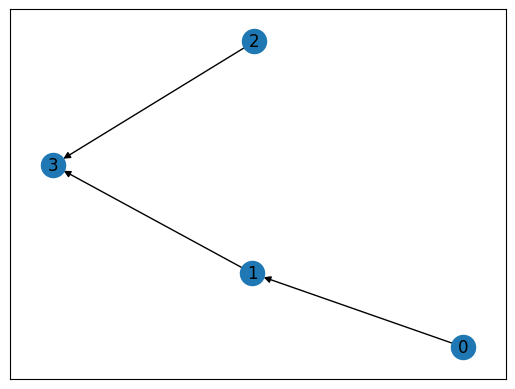

In [63]:
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
nx.draw_networkx(h.to_networkx(), with_labels = True)

DGLGraph.apply_nodes

In [72]:
#Update the features of the specified nodes by the provided function.
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2) #features of nodes
h.apply_nodes(lambda nodes:{'x' : np.sin(nodes.data['h'])}) #user_ defined finction
                                                      # exp : nodes.data['h'] = h.nodes[1].data['h']
print('h:',h.ndata['h'])
print('\n')
print('x:', h.ndata['x'])

h: tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])


x: tensor([[0.8415, 0.8415],
        [0.8415, 0.8415],
        [0.8415, 0.8415],
        [0.8415, 0.8415]])


DGLGraph.apply_edges

In [73]:
# Update the features of the specified edges by the provided function.
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2) #features of nodes
h.apply_edges(lambda edges : {'x': edges.src['h']+ edges.dst['h']+1}) # user definded :
                                                                    # give edge ; edge feature (A, B) = feature node (A) + feature node (B) +1
h.edata['x']

tensor([[3., 3.],
        [3., 3.],
        [3., 3.]])

DGLGraph.send_and_recv

In [74]:
# Send messages along the specified edges and reduce them on the destination nodes to update their features
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2) #features of nodes

# Define the function for sending node features as messages.
def send_source(edges):
  return {'m': edges.src['h']} #given edges, then send it's source node features as message.

# Sum the messages received and use this to replace the original node feature.
def simple_reduce(nodes):
  return {'x': nodes.mailbox['m'].sum(1)}


h.send_and_recv(([0, 2], [1, 3]), send_source, simple_reduce )
h.ndata['x']

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        [1., 1.]])

dgl.DGLGraph.pull

In [76]:
#Pull messages from the specified node(s)’ predecessors along the specified edge type, aggregate them to update the node features.
import dgl.function as fn
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
h.pull([0, 3], fn.copy_u('h', 'm'), fn.mean('m', 'x')) #fn.copy_u('h', 'm') is message function
                                                      # fn.mean('m', 'x') is reduce function
h.ndata['x']
#node 0 has no input then it's feature doesn't updata
#node 3 update it's feature according to feature of node 2

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.]])

dgl.DGLGraph.push

In [79]:
#Send message from the specified node(s) to their successors along the specified edge type and update their node features.
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
h.push([0, 2], fn.copy_u('h', 'm'), fn.mean('m', 'x')) #fn.copy_u('h', 'm') is message function
                                                      # fn.sum('m', 'x') is reduce function
h.ndata['x']

#feature of node 0 is send to node 1
#feature of node 2 is send to node 3

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        [1., 1.]])

dgl.DGLGraph.update_all

In [78]:
#Send messages along all the edges of the specified type and update all the nodes of the corresponding destination type.
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
h.update_all(fn.copy_u('h', 'm'), fn.mean('m', 'x')) #fn.copy_u('h', 'm') is message function
                                                      # fn.mean('m', 'x') is reduce function
h.ndata['x']
#The features of all nodes update except node 0 and 2 because they have no input.

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        [1., 1.]])

dgl.function.copy_u

In [41]:
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)

message_func = dgl.function.copy_u('h', 'm')

def simple_reduce(nodes):
  return {'x': nodes.mailbox['m'].sum(1)}


h.send_and_recv(([0, 1], [1, 2]), message_func, simple_reduce )
h.ndata['x']

tensor([[0., 0.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [0., 0.]])

In [42]:
h = dgl.graph(([0, 1, 2, 3], [1, 2, 3, 4]))
h.ndata['h'] = torch.ones(5, 2)
message_func = dgl.function.copy_u('h', 'm')
h.pull([0, 3], message_func , fn.sum('m', 'x'))

h.ndata['x']

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [0., 0.]])

In [43]:
h = dgl.graph(([0, 1, 2, 3], [1, 2, 3, 4]))
h.ndata['h'] = torch.ones(5, 2)
message_func = dgl.function.copy_u('h', 'm')
h.push([0, 3], message_func , fn.sum('m', 'x'))

h.ndata['x']

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [1., 1.]])

In [86]:
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
message_func = dgl.function.copy_u('h', 'm')
h.update_all(message_func , fn.sum('m', 'x'))

h.ndata['x']

#node 0 and 2 have no  upadata feature because they have no input
#node 3 has two input

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        [2., 2.]])

dgl.function.copy_e

In [88]:
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.edata['h'] = torch.ones(3, 2)
message_func = dgl.function.copy_e('h', 'm')
h.update_all(message_func , fn.sum('m', 'x'))

h.ndata['x']

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        [2., 2.]])

dgl.function.u_add_v

In [90]:
#Builtin message function that computes a message on an edge by performing element-wise add between features of u and v if the features have the same shape
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
message_func = dgl.function.u_add_v('h', 'h', 'm')
h.update_all(message_func , fn.sum('m', 'x'))

#features of node 0 ADD TO feature of node 1 ---> updata feature of node 1
#features of node 1 ADD TO feature of node 3 ---> updata feature of node 3
#features of node 2 ADD TO feature of node 3 ---> updata feature of node 3
#updata feature of node 3 + updata feature of node 3
h.ndata['x']

tensor([[0., 0.],
        [2., 2.],
        [0., 0.],
        [4., 4.]])

dgl.function.u_mul_v

In [91]:
#Builtin message function that computes a message on an edge by performing element-wise mul between features of u and v if the features have the same shape;
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
message_func = dgl.function.u_mul_v('h', 'h', 'm')
h.update_all(message_func , fn.sum('m', 'x'))

#features of node 0 * feature of node 1 ---> updata feature of node 1
#features of node 1 * feature of node 3 ---> updata feature of node 3
#features of node 2 * feature of node 3 ---> updata feature of node 3
#updata feature of node 3 + updata feature of node 3
h.ndata['x']

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        [2., 2.]])

dgl.function.u_add_e

In [94]:
#Builtin message function that computes a message on an edge by performing element-wise add between features of u and e if the features have the same shape; otherwise, it first broadcasts the features to a new shape and performs the element-wise operation.
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
h.edata['h'] = torch.ones(3, 2)
message_func = dgl.function.u_add_e('h', 'h', 'm')
h.update_all(message_func , fn.sum('m', 'x'))

#features of node 0 ADD TO feature of edge(0, 1) ---> updata feature of node 1
#features of node 1 ADD TO feature of edge(1, 3)---> updata feature of node 3
#features of node 2 ADD TO * feature of edge(2, 3) ---> updata feature of node 3
#updata feature of node 3 + updata feature of node 3
h.ndata['x']

tensor([[0., 0.],
        [2., 2.],
        [0., 0.],
        [4., 4.]])

dgl.function.u_mul_e

In [95]:
#Builtin message function that computes a message on an edge by performing element-wise mul between features of u and e if the features have the same shape; otherwise, it first broadcasts the features to a new shape and performs the element-wise operation.
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
h.edata['h'] = torch.ones(3, 2)
message_func = dgl.function.u_mul_e('h', 'h', 'm')
h.update_all(message_func , fn.sum('m', 'x'))

#features of node 0 * feature of edge(0, 1) ---> updata feature of node 1
#features of node 1 * feature of edge(1, 3)---> updata feature of node 3
#features of node 2 * feature of edge(2, 3) ---> updata feature of node 3
#updata feature of node 3 + updata feature of node 3
h.ndata['x']

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        [2., 2.]])

dgl.function.v_add_u

In [96]:
#Builtin message function that computes a message on an edge by performing element-wise add between features of v and u if the features have the same shape; otherwise, it first broadcasts the features to a new shape and performs the element-wise operation.
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
message_func = dgl.function.v_add_u('h', 'h', 'm')
h.update_all(message_func , fn.sum('m', 'x'))

#features of node 1 ADD TO feature of edge node 0 ---> updata feature of node 1
#features of node 3 ADD TO  feature of node 1 ---> updata feature of node 3
#features of node 3 ADD TO  feature of node 2 ---> updata feature of node 3
#updata feature of node 3 + updata feature of node 3
h.ndata['x']

#Same as u add v ??

tensor([[0., 0.],
        [2., 2.],
        [0., 0.],
        [4., 4.]])

dgl.function.v_mul_u

In [97]:
#Builtin message function that computes a message on an edge by performing element-wise mul between features of v and u if the features have the same shape; otherwise, it first broadcasts the features to a new shape and performs the element-wise operation.
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
message_func = dgl.function.v_mul_u('h', 'h', 'm')
h.update_all(message_func , fn.sum('m', 'x'))

#features of node 1 * feature of node 0 ---> updata feature of node 1
#features of node 3 * feature of node 1 ---> updata feature of node 3
#features of node 3 * feature of node 2 ---> updata feature of node 3
#updata feature of node 3 + updata feature of node 3
h.ndata['x']

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        [2., 2.]])

dgl.function.v_add_e

In [99]:
#Builtin message function that computes a message on an edge by performing element-wise add between features of v and e if the features have the same shape; otherwise, it first broadcasts the features to a new shape and performs the element-wise operation.
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
h.edata['h'] = torch.ones(3, 2)
message_func = dgl.function.v_add_e('h', 'h', 'm')
h.update_all(message_func , fn.sum('m', 'x'))

#features of node 1 ADD TO feature of edge(0, 1) ---> updata feature of node 1
#features of node 3 ADD TO feature of edge(1, 3)---> updata feature of node 3
#features of node 3 ADD TO * feature of edge(2, 3) ---> updata feature of node 3
#updata feature of node 3 + updata feature of node 3
h.ndata['x']

tensor([[0., 0.],
        [2., 2.],
        [0., 0.],
        [4., 4.]])

dgl.function.v_mul_e

In [100]:
#Builtin message function that computes a message on an edge by performing element-wise mul between features of v and e if the features have the same shape; otherwise, it first broadcasts the features to a new shape and performs the element-wise operation.
h = dgl.graph(([0, 1, 2], [1, 3, 3]))
h.ndata['h'] = torch.ones(4, 2)
h.edata['h'] = torch.ones(3, 2)
message_func = dgl.function.v_mul_e('h', 'h', 'm')
h.update_all(message_func , fn.sum('m', 'x'))

#features of node 1 * feature of edge(0, 1) ---> updata feature of node 1
#features of node 3 * feature of edge(1, 3)---> updata feature of node 3
#features of node 3 * feature of edge(2, 3) ---> updata feature of node 3
#updata feature of node 3 + updata feature of node 3
h.ndata['x']

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        [2., 2.]])